In [56]:
# packages
import pandas as pd
# import pyarrow.dataset as ds
# import pyarrow as pa
# from datasets import *
# from transformers import *
from tokenizers import *
import os
import json
import sys
# from tokenizers.processors import BertProcessing
import numpy as np

In [57]:
# INPORTANT
# out_dir = './task_devign_v3'
# raw_data_path = '/scratch/xin/devign_task/tokenized_devign_v3.pkl'
# model_path = '/scratch/xin/bert_source_v3/pretrained-bert/'
num_epochs = 20
max_step_saves = 3
save_step_at = 1000
learning_rate = 5e-5
adam_epsilon = 1e-8
CLASSIFIER_HIDDEN_SIZE = 128
MIDDLE_LAYER_DROPOUT = 0.2
normalize = 'ReLU'
t5_checkpoint = "t5-base"

MAX_LENGTH = 1024
test_only = False
data_type = 'devign'
out_dir = '../result_duo_mode_{}_{}_with_tagging'.format(data_type, MAX_LENGTH)

# # redas-lab2
# data_dir = "/scratch/dna_data/{}".format(data_type)
# bert_model_path = '/scratch/pretrained-dna-bert/checkpoint-35000'
# tokenizer_path = '/scratch/pretrained-dna-bert/'
# batch_size = 4  # 8GB per GPU   

# # carya cluster
data_dir = "../../dna_data_lite_2/{}".format(data_type)
bert_model_path = '../pretrained-dna-roberta-2/checkpoint-40000'
tokenizer_path = '../../dna_data_pretraining_2/BPE_tokenizer'
batch_size = 16 # 32GB per GPU -  max_length 512: 32 -max_length 1024: 16


truncate_longer_samples = True

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
log_txt_file = os.path.join(out_dir, 'log.txt')
# intialization
with open(log_txt_file, 'w+') as f:
    f.write('- log -\n')

def log_txt(s, type='normal'):
    with open(log_txt_file, 'a') as f:
        f.write('{} - {}\n'.format( type, s))

# intial parameters
log_txt('data_type: {}'.format(data_type))
log_txt('data_dir: {}'.format(data_dir))
log_txt('out_dir: {}'.format(out_dir))
log_txt('bert_model_path: {}'.format(bert_model_path))
log_txt('tokenizer_path: {}'.format(tokenizer_path))
log_txt('MAX_LENGTH: {}'.format(MAX_LENGTH))
log_txt('batch_size: {}'.format(batch_size))
log_txt('num_epochs: {}'.format(num_epochs))
log_txt('save_step_at: {}'.format(save_step_at))
log_txt('learning_rate: {}'.format(learning_rate))
log_txt('adam_epsilon: {}'.format(adam_epsilon))
log_txt('normalize: {}'.format(normalize))
log_txt('CLASSIFIER_HIDDEN_SIZE: {}'.format(CLASSIFIER_HIDDEN_SIZE))


In [58]:
# load data
from sklearn.model_selection import train_test_split

def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'text-t5': [], 'label': []}
    for i in range(len(raw_df['code'])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['text-t5'].append(raw_df['code-2'][i])
        df['label'].append(raw_df['label'][i])
    df = pd.DataFrame(df)
    return df
    ### convert to Huggingface dataset
#     return Dataset(pa.Table.from_pandas(df))

# random split into train/valid/test
if data_type in ['devign']:
    raw_data_path = os.path.join(data_dir, 'all.pkl')
    tokenized_data = get_data(raw_data_path)
    print(len(tokenized_data))
    train_data, valid_data, test_data = np.split(tokenized_data, [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
# load train/valid/test
elif data_type in ['mvdsc', 'd2a' ]:
        train_data = get_data(os.path.join(data_dir, 'train.pkl'))
        valid_data = get_data(os.path.join(data_dir, 'valid.pkl'))
        test_data = get_data(os.path.join(data_dir, 'test.pkl'))
# load train/valid/test from 4 types
elif data_type in ['sysevr']:
    # already randomized from pre-processing with fixed seed for pre-training and fine-tuning
    raw_data_path = os.path.join(data_dir, 'api.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_1, valid_data_1, test_data_1 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'au.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_2, valid_data_2, test_data_2 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'ae.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_3, valid_data_3, test_data_3 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'pu.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_4, valid_data_4, test_data_4 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    tokenized_data = get_data(raw_data_path)
    train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)
    valid_data = pd.concat([valid_data_1, valid_data_2, valid_data_3, valid_data_4], ignore_index=True)
    test_data = pd.concat([test_data_1, test_data_2, test_data_3, test_data_4], ignore_index=True)
elif  data_type in ['draper']:
    # splitted data bc too large
    all_data = {}
    for i in range(10):
        raw_data_path = os.path.join(data_dir, 'train_{}.pkl'.format(i))
        tokenized_data = get_data(raw_data_path)
        #train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)

else:
    print('data type does not exist!')


In [59]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data['text'][:3])

log_txt('train: {} - valid: {} - test: {} '.format(len(train_data), len(valid_data), len(test_data)))

(1000, 3)
(1000, 3)
(1000, 3)
0    translation_unit void function_declarator CWE1...
1    translation_unit static function_definition vo...
2    translation_unit void function_declarator CWE1...
3    translation_unit static function_definition vo...
4    translation_unit static function_definition vo...
5    translation_unit static function_definition vo...
6    translation_unit void function_declarator CWE1...
7    translation_unit void function_declarator CWE1...
8    translation_unit void function_declarator CWE1...
9    translation_unit static function_definition vo...
Name: text, dtype: object


In [60]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [61]:
train_texts = train_data['text'].values
train_texts_2 = train_data['text-t5'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_texts_2 = valid_data['text-t5'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_texts_2 = test_data['text-t5'].values
test_labels = test_data['label'].values

print(train_texts[0])

translation_unit void function_declarator CWE121_Stack_Based_Buffer_Overflow__CWE805_wchar_t_alloca_ncat_05_bad parenthesized_expression ( ERROR ) compound_statement { declaration wchar_t pointer_declarator * identifier wchar_tPointerDefUsePass   declaration wchar_t pointer_declarator * identifier wchar_tPointerDefUseCall = parenthesized_expression ( declaration wchar_t pointer_declarator * ERROR ) call_expression ALLOCA parenthesized_expression ( binary_expression 5 0 pointer_declarator * sizeof_expression sizeof parenthesized_expression ( declaration wchar_t ERROR ) ERROR )   if_statement if parenthesized_expression ( identifier staticTrue ERROR ) compound_statement { identifier wchar_tPointerDefUsePass = identifier wchar_tPointerDefUseCall   identifier wchar_tPointerDefUsePass [ number_literal 0 ] = identifier L char_literal ' escape_sequence \0 char_literal '   declaration wchar_t expression_statement source [ number_literal 1 0 0 ]   expression_statement wmemset parenthesized_expr

In [62]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
log_txt(' -------------------- train_texts -------------------- ')
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))


train_texts_2[0]
text_lengths = [len(train_texts_2[i].split()) for i in range(len(train_texts_2))]
log_txt(' -------------------- train_texts_2 -------------------- ')
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))
    

min:  28
number of zeros:  0
max:  548
avg:  184.785
median:  163
95%:  406
184.785
87.67309362824119


C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\2095679928.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


Text(0, 0.5, 'counts')

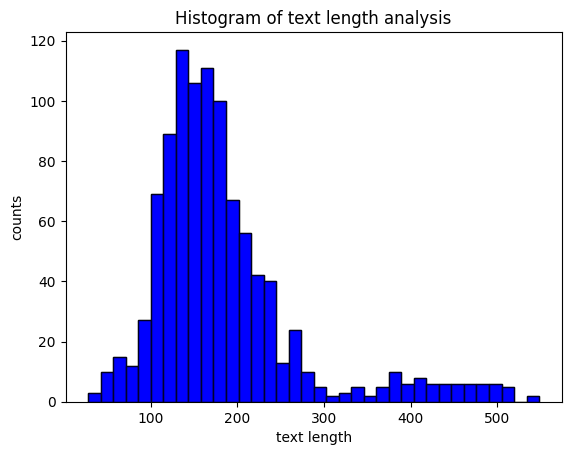

In [63]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')
plt.savefig(os.path.join(out_dir, 'histogram.png'))

In [64]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

4

In [65]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 32010
# maximum sequence length, lowering will result to faster training (when increasing batch size)
import sentencepiece as spm
import transformers 
# !pip install sentencepiece

from tokenizers import SentencePieceBPETokenizer

if 'albert' in tokenizer_path:
    tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_path)

log_txt('tokenizer_path: {}\n'.format( tokenizer_path))


t5_tokenizer = transformers.AutoTokenizer.from_pretrained(t5_checkpoint)


C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\tokenization_utils_base.py:1678: FutureWarning: Calling AlbertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
loading file ..\..\cbert\pretrained\test_albert_NaCUT\tokenizer.model
Adding [CLS] to the vocabulary
Adding [SEP] to the vocabulary
Adding <pad> to the vocabulary
Adding [MASK] to the vocabulary
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


..\..\cbert\pretrained\test_albert_NaCUT\tokenizer.model
tokenizer loaded ...
vocab size:  32000


In [66]:

max_length = MAX_LENGTH
train_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in train_texts]
valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in valid_texts]
test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in test_texts]


train_text_ids_2 = [t5_tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True).input_ids  for t in train_texts_2]
valid_text_ids_2 = [t5_tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True).input_ids  for t in valid_texts_2]
test_text_ids_2 = [t5_tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True).input_ids  for t in test_texts_2]



In [67]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]

# train_text_ids_2 = [text_id['input_ids'] for text_id in train_text_dict_2]
# valid_text_ids_2 = [text_id['input_ids'] for text_id in valid_text_dict_2]
# test_text_ids_2 = [text_id['input_ids'] for text_id in test_text_dict_2]

# text_ids[0]
train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]


In [68]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_x_2, train_y = train_text_ids, train_att_masks, train_text_ids_2, train_labels
val_x, val_m, val_x_2, val_y = valid_text_ids, valid_att_masks, valid_text_ids_2, valid_labels
test_x, test_m, test_x_2, test_y = test_text_ids, test_att_masks, test_text_ids_2, test_labels

In [69]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)

train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)

train_x_2 = torch.tensor(train_x_2)
test_x_2 = torch.tensor(test_x_2)
val_x_2 = torch.tensor(val_x_2)


train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

# log_txt(train_x.shape)
# log_txt(test_x.shape)
# log_txt(val_x.shape)
# log_txt(test_y.shape)
# log_txt(val_y.shape)
# log_txt(train_m.shape)
# log_txt(test_m.shape)
# log_txt(val_m.shape)

torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])


In [70]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# log_txt(train_x)
train_data = TensorDataset(train_x, train_m, train_x_2, train_y)
train_sampler = list(range(len(train_data)))


# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_x, val_m, val_x_2, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# train_loader_extracted = torch.utils.data.DataLoader(train_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=train_sampler)

# valid_loader_extracted = torch.utils.data.DataLoader(valid_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=val_sampler)


tensor([[32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        ...,
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ..., 32002, 32002, 32002]])


In [ ]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys

class DotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(
            torch.Tensor(1, hidden_size), requires_grad=True)
        init.xavier_uniform(self.attn_vector.data)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths=None):
        batch_size, max_len = inputs.size()[:2]
        '''
        print("INPUTS", inputs.size())
        print("ATTN", self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .transpose(2, 1)
                            .repeat(batch_size, 1, 1).size())'''
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, 1, hidden_size)
                            .transpose(2, 1) # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1)) # (batch_size, hidden_size, 1))
        attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
        # create mask based on the sentence lengths
        #idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0).cuda()  # some day, you'll be able to directly do this on cuda
        #mask = Variable((idxes < lengths.data.unsqueeze(1)).float())
        # apply mask and renormalize attention scores (weights)
        #masked = attn_weights * mask
        _sums = attn_energies.sum(-1).unsqueeze(1).expand_as(attn_energies)  # sums per row
        attn_weights = attn_energies / _sums
        # print('attn_weights: ', attn_weights.shape)
        # apply attention weights
        weighted = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))
        # print('weighted: ', weighted.shape)
        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        if len(representations.shape) == 1:
            representations = representations.reshape(1, representations.shape[-1])
        # print('representations: ', representations.shape)
        return representations, attn_weights
    
from transformers import AutoModelForSequenceClassification


    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
        self.hidden_size = CLASSIFIER_HIDDEN_SIZE
        intermediate_size = 2
        ########### T5 model
        self.model  = transformers.AutoModel.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.T5 = transformers.T5EncoderModel.from_pretrained(t5_checkpoint)
        self.attn_t5 = DotAttention(hidden_size = 768)
        self.t5_classifier = nn.Linear(768 * 2, intermediate_size) # load and initialize weights
        self.dropout_t5 = nn.Dropout(MIDDLE_LAYER_DROPOUT)

        ############ BERT model
        self.attn = DotAttention(hidden_size = 768)
        self.bert_classifier = nn.Linear(768 * 2, intermediate_size) # load and initialize weights
        self.dropout_bert = nn.Dropout(MIDDLE_LAYER_DROPOUT)

        # CONCATENATED:
        # self.concat_classifier = nn.Linear(num_labels * (MAX_LENGTH // 512), num_labels) # load and initialize weights

        ########### NORMALIZATION
        if normalize == 'GELU':
            self.normalization = nn.GELU()
        elif normalize == 'Softmax':
            self.normalization = nn.Softmax()
        else:
            self.normalization = nn.ReLU()

        ############ FINAL CLASSIDIER
        self.concat_classifier = nn.Linear(intermediate_size * 2 * (MAX_LENGTH // 512), num_labels) # load and initialize weights
        self.dense_1 = nn.Linear(MAX_LENGTH // 512 * 768 * 2, 768) 
        self.dense_2 = nn.Linear(768, 192)
        self.dense_3 = nn.Linear(192, num_labels)  
        # self.activation = nn.Sigmoid()
    
    
    def forward_single(self, input_ids, attention_mask, input_ids_2, labels, ex):
        # BERT model
        all_outputs = self.model(input_ids, attention_mask=attention_mask)
        hidden_states_bert = all_outputs[0]
        pooler_output_bert = all_outputs[1]
        attention_weights_bert = all_outputs[3]
        # attn, attention_weights_dot_product = self.attn.forward(hidden_states_bert)
        # concatenated_bert = torch.cat([pooler_output_bert, attn], dim=1)
        # output_bert =  self.bert_classifier(pooler_output_bert)
        # batch_size x 2
        # output_bert = self.activation(output_bert)
        # T5 model
        hidden_states_t5 = self.T5(input_ids=input_ids_2)
        hidden_states_t5 = hidden_states_t5.last_hidden_state
        pooler_output_t5 =  hidden_states_t5[:,-1]   
        #t5_attn, attention_weights_dot_product_t5 = self.attn_t5.forward(hidden_states_t5)
        #concatenated_t5 = torch.cat([pooler_output_t5, t5_attn], dim=1)
        # output_t5 =  self.t5_classifier(pooler_output_t5)
        # batch_size x 2
        # output_t5 = self.activation(output_t5)

        # hidden_states_bert: batch x 512 x 768 pooler_output_bert: batch x 768
        return pooler_output_bert, pooler_output_t5, attention_weights_bert[0]
        # concatenation
        # concatenated_final = torch.cat([output_bert, output_t5], dim=1)
        # return self.normalization(output_bert), self.normalization(output_t5),  attention_weights_dot_product, attention_weights_dot_product_t5
    
    def forward(self, input_ids=None, attention_mask=None, input_ids_2=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        # Extract outputs from the body
        all_output_bert = None
        all_output_t5 = None
        all_attention_weights_bert = None
        # pick the most suspicous one for final decision
        for i in range(0, max_len, 512):
            output_bert, output_t5, attention_weights_bert  = \
                    self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], input_ids_2[:,i:i+512], labels, ex)
            if all_output_bert is None:
                # BERT
                all_output_bert = output_bert
                all_attention_weights_bert = attention_weights_bert
                # T5
                all_output_t5 = output_t5
            else:
                # BERT
                all_output_bert = torch.cat([all_output_bert,  output_bert], dim=1)
                all_attention_weights_bert = torch.cat([all_attention_weights_bert,  attention_weights_bert], dim=1)
                # T5
                all_output_t5 = torch.cat([all_output_t5,  output_t5], dim=1)
        # late fusion - concatenation
        # batch x 3072 MAX_LENTH
        all_concatenated = torch.cat([nn.ReLU()(all_output_bert), nn.ReLU()(all_output_t5)], dim=1)
        # 3072 - > 768
        final_output = nn.ReLU()(self.dense_1(all_concatenated))
        # 768 -> 192
        final_output = nn.ReLU()(self.dense_2(final_output))
        # 192 -> 2
        final_output = nn.Sigmoid()(self.dense_3(final_output))

        loss = None
        if labels is not None:
            # print(labels.view(-1).shape)
            loss_fct = nn.CrossEntropyLoss()
            # loss = loss_fct(final_output.view(-1, self.num_labels), labels.view(-1))
            loss = loss_fct(final_output, labels)
        return (loss, final_output), all_attention_weights_bert

        #return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [72]:
log_txt(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

loading configuration file ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint\config.json
Model config AlbertConfig {
  "_name_or_path": "..\\..\\cbert\\pretrained\\test_albert_NaCUT\\checkpoint",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 8192,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "vocab_size": 32010
}

loading weights file ..\..\cbert\pretrained\test_

..\..\cbert\pretrained\test_albert_NaCUT\checkpoint


Some weights of AlbertModel were not initialized from the model checkpoint at ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.attn_vector.data)


In [73]:



no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [74]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)
model = model.cuda()

In [75]:

from transformers import get_linear_schedule_with_warmup


total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [76]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os


# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
print('number of iterations: ', len(train_dataloader))

number of iterations:  125


In [77]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, mb_m, mb_x_2, mb_y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()

            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_x_2 = mb_x_2.cuda()
            mb_y = mb_y.cuda()
            #ex = ex.cuda()

            outputs, _, = model(mb_x, attention_mask=mb_m, input_ids_2=mb_x_2, labels=mb_y)
            #print(outputs[1])
            #mb_y = F.one_hot(mb_y)
            #print(outputs, mb_y)
            #loss = loss_fct(outputs.view(-1, 2), mb_y.view(-1))
            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-1]) )
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-(max_step_saves+1)]))
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, mb_m, mb_x_2, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                mb_m = mb_m.cuda()
                mb_x_2 = mb_x_2.cuda()
                mb_y = mb_y.cuda()
                
                outputs, _ = model(mb_x, attention_mask=mb_m, input_ids_2=mb_x_2, labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best

            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = os.path.join(out_dir, 'classification_model_best')
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break


    out_dir_model = os.path.join(out_dir, 'classification_model_last')
    save_model(model, train_losses, val_losses, out_dir_model)
    print('model saved as: ', out_dir_model)

num_epochs:  10


0it [00:00, ?it/s]C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_logits = self.softmax(final_logits)
99it [00:37,  2.62it/s]

saved as:  ./result_mvdsc/classification_model_100


125it [00:47,  2.63it/s]



Train loss after itaration 1: 0.379066
Validation loss after itaration 1: 0.306936
val_losses:  [] 0.3069362938404083
Time: 1m 4s


74it [00:30,  2.19it/s]

saved as:  ./result_mvdsc/classification_model_200


125it [00:50,  2.48it/s]



Train loss after itaration 2: 0.288924
Validation loss after itaration 2: 0.255616
val_losses:  [0.3069362938404083] 0.2556156516075134
the best model updated
saved as:  ./result_mvdsc/classification_model_best
Time: 1m 7s


49it [00:18,  2.66it/s]

saved as:  ./result_mvdsc/classification_model_300


125it [00:47,  2.64it/s]



Train loss after itaration 3: 0.244448
Validation loss after itaration 3: 0.323779
val_losses:  [0.3069362938404083, 0.2556156516075134] 0.3237793445587158
Time: 1m 4s


24it [00:09,  2.66it/s]

saved as:  ./result_mvdsc/classification_model_400


124it [00:47,  2.65it/s]

saved as:  ./result_mvdsc/classification_model_500


125it [00:47,  2.62it/s]



Train loss after itaration 4: 0.213758
Validation loss after itaration 4: 0.274534
val_losses:  [0.3069362938404083, 0.2556156516075134, 0.3237793445587158] 0.2745341956615448
Time: 1m 4s


99it [00:37,  2.66it/s]

saved as:  ./result_mvdsc/classification_model_600


125it [00:47,  2.63it/s]



Train loss after itaration 5: 0.170058
Validation loss after itaration 5: 0.335586
val_losses:  [0.3069362938404083, 0.2556156516075134, 0.3237793445587158, 0.2745341956615448] 0.3355863690376282
Time: 1m 4s


[0.3069362938404083, 0.2556156516075134, 0.3237793445587158, 0.2745341956615448]


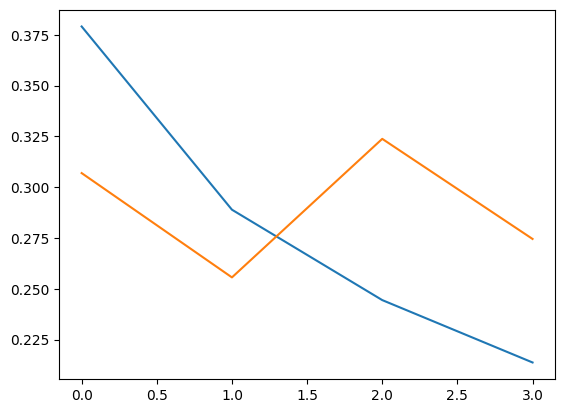

In [88]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_last'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.savefig(os.path.join(out_dir, 'train_valid_loss.png'))

In [89]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_x_2, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m, mb_x_2) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
        mb_x2_2 = mb_x_2.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m, input_ids_2=mb_x_2, max_len=MAX_LENGTH, opt='mean')
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

num of iterations:  125


0it [00:00, ?it/s]C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_logits = self.softmax(final_logits)
125it [00:17,  7.05it/s]


In [90]:
print(outputs[:10])
print(test_y[:10])
true_values = test_y.numpy()

################################################
## OPTIONAL: to find best detection threshold ##
results = []
for i in range(100):
    prediction_probs = outputs[:,1]
    detection_threshold = i / 100
    predictions = [1 if x >= detection_threshold else 0 for x in list(prediction_probs)]
    test_accuracy = np.sum(predictions == true_values) / len(true_values)
    results.append(test_accuracy)
results = sorted(results)
print('lowest: ', results[:5])
print('highest: ', results[-5:])
################################################


_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

log_txt("Test Accuracy: {}".format(test_accuracy))


Test Accuracy: 0.897


In [91]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[668  43]
 [ 60 229]]
Normalized confusion matrix
[[0.94 0.06]
 [0.21 0.79]]


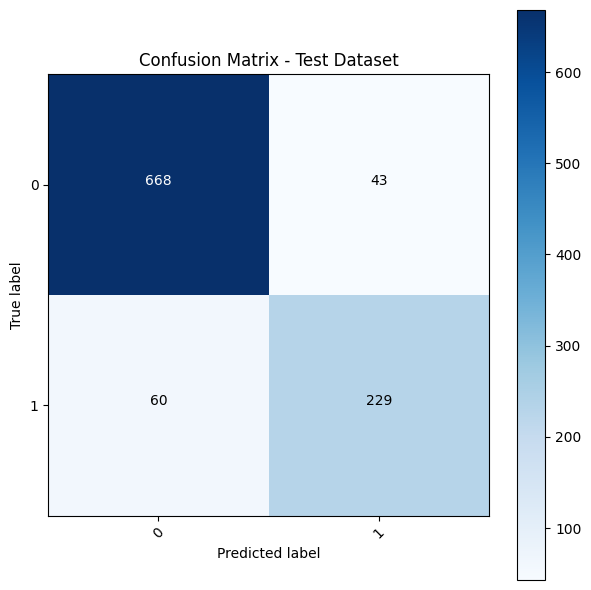

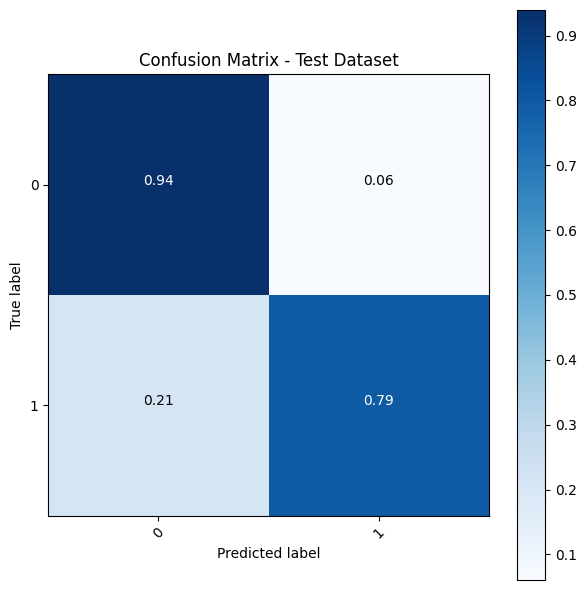

In [92]:
# from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics

def confusion_matrix_scorer(y_pred, y):
    cm = metrics.confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
        'fn': cm[1, 0], 'tp': cm[1, 1]}

cm_test = metrics.confusion_matrix(true_values, predicted_values)
print({ 'tn': cm_test[0, 0], 'fp': cm_test[0, 1],
        'fn': cm_test[1, 0], 'tp': cm_test[1, 1]})

log_txt('tn: {} - fp: {} - fn: {} - tp: {}'.format(cm_test[0, 0], cm_test[0, 1], cm_test[1, 0], cm_test[1, 1]))
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')

plt.savefig(os.path.join(out_dir, 'confusion_matrix.png'))

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

plt.savefig(os.path.join(out_dir, 'confusion_matrix_normalized.png'))